## Word Embeddings for Fun and Profit
### Document classification with Gensim

In this tutorial we'll classify movie plots by genre using word embeddings techniques in [gensim](http://radimrehurek.com/gensim/) . 

See accompanying slides in this repo.

We will show how to get a __'hello-world'__ first untuned run using 7 techniques:

- Bag of words

- Character n-grams

- TF-IDF 

- Averaging word2vec vectors

- doc2vec

- Deep IR 

- Word Mover's Distance

The goal of this tutorial is to show the API so you can start tuning them yourself. Model tuning of the models is out of scope of this tutorial.

We will also compare the accuracy of this first 'no tuning'/out of the box run of these techniques. It is in no way an indication of their best peformance that can be achieved with proper tuning. The benefit of the comparison is to manage the expectations.

## Requirements
- Python 3
- [Google News pre-trained word2vec (1.5 GB)](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- gensim
- sklearn
- pandas
- matplotlib
- nltk with English stopwords
- pyemd
- 4 GB RAM
- 8 GB disk space for WMD

## Dataset

In [1]:
from functions import *

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

## Exploring the data



In [4]:
df = pd.read_pickle('metatable_preprocessed.pkl')

In [5]:
df.groupby('tradition')['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

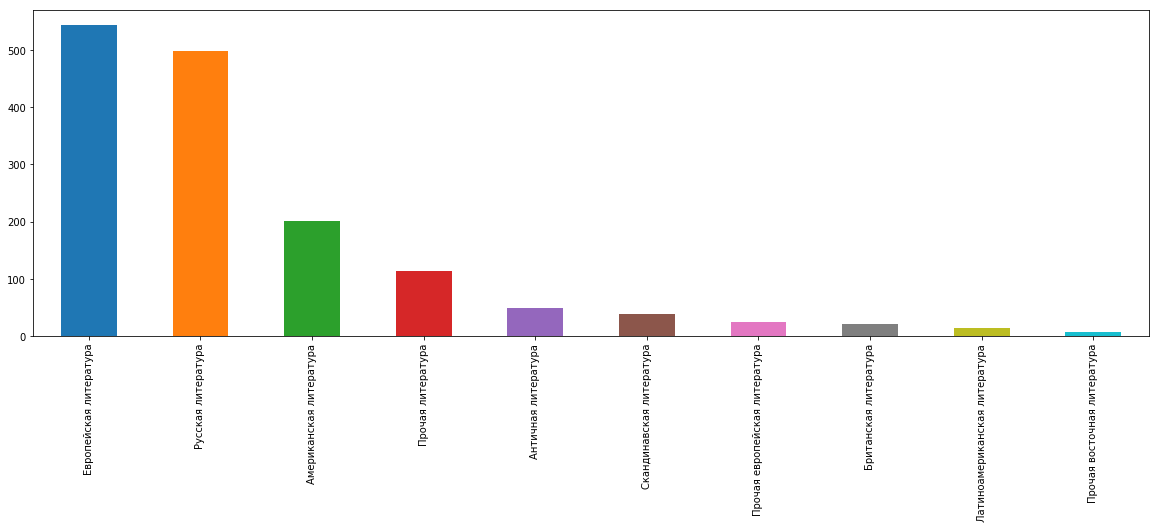

In [6]:
df.tradition.value_counts().plot(kind="bar")

In [7]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

1925532

In [8]:
print_plot(df, 12, 'tradition')

Миссис Кремона — немолодая женщина с ласковой улыбкой и ясным кротким взглядом, пришла в огромное правительственное здание к сыну Джеральду, видному физику. Он был очень занят — беседовал с генералом Райнером. Генерал усомнился в уместности присутствия матушки Джеральда при их разговоре. Джеральд успокоил его — матушка ничего не понимает в их делах. Он объяснял генералу ситуацию. Одна из экспедиций, которая была отправлена за пояс астероидов, достигла Плутония. Они подают радиосигналы. Загадка в том, что люди отправились в полёт четыре года назад, а всех припасов им могло хватить от силы на год. Джеральд предположил, что, возможно, им помогают жители других планет. Надо срочно узнать, что происходит. Может быть, от этого зависит будущее человечества. Для этого нужен электронный мозг Мультивак. От Земли до Плутония около четырёх миллиардов миль. Даже если радиоволны будут распространяются со скоростью света, то они покроют это расстояние за шесть часов, значит, ответа придётся ждать две

### Train/test split

In [9]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
len(test_data)

302

In [11]:
df.groupby('tradition')['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

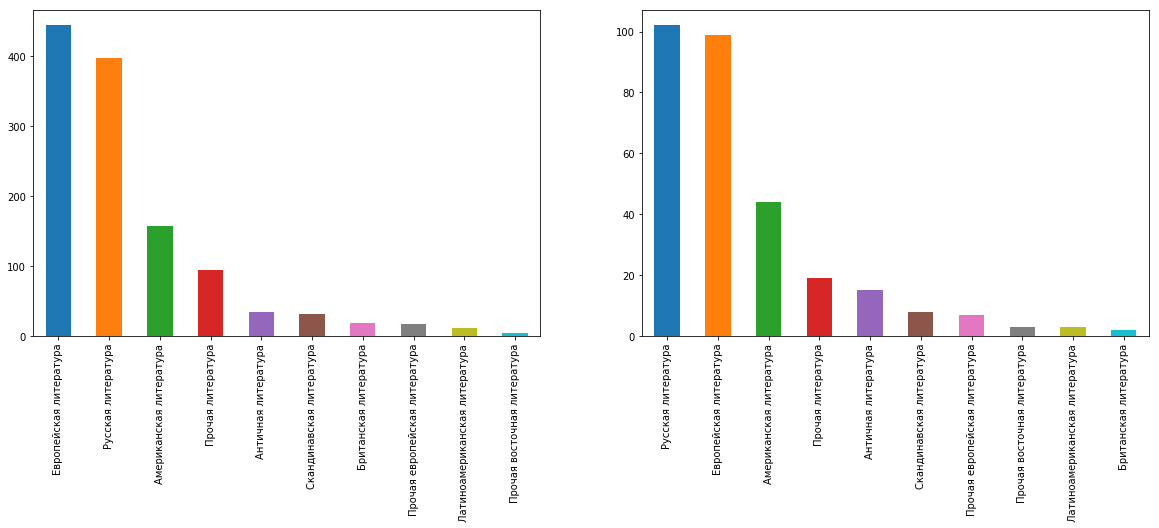

In [12]:
fig, axs = plt.subplots(1,2)
train_data.tradition.value_counts().plot(kind="bar", ax=axs[0])
test_data.tradition.value_counts().plot(kind="bar", ax=axs[1])

In [13]:
traditions = ['Американская литература', 'Античная литература',
       'Британская литература', 'Европейская литература',
       'Латиноамериканская литература', 'Прочая восточная литература',
       'Прочая европейская литература', 'Прочая литература',
       'Русская литература', 'Скандинавская литература']

## Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

In [14]:
STOPWORDS = stopwords.words('russian')
TOKENIZER = nltk.word_tokenize

### Bag of words

The simplest document feature is just a count of each word occurrence in a document.

In [15]:
%%time

count_vectorizer = CountVectorizer(analyzer="word", max_features=3000, tokenizer=TOKENIZER, stop_words=STOPWORDS) 
train_data_features = count_vectorizer.fit_transform(train_data['text'])

CPU times: user 43 s, sys: 410 ms, total: 43.4 s
Wall time: 43.9 s


In [16]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tradition'])

CPU times: user 2.39 s, sys: 4.42 ms, total: 2.4 s
Wall time: 2.4 s


In [17]:
count_vectorizer.get_feature_names()[2680:2700]

['той',
 'толпа',
 'толпы',
 'тома',
 'томас',
 'томми',
 'тому',
 'тони',
 'тотчас',
 'точки',
 'точно',
 'трагедии',
 'требует',
 'требуют',
 'третий',
 'третьего',
 'третья',
 'тридцать',
 'трое',
 'троих']

accuracy 0.6854304635761589
confusion matrix
 [[24  0  0 10  0  0  1  1  8  0]
 [ 0 11  0  2  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 6  0  0 75  0  0  0  3 15  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  1  1  0]
 [ 2  0  0  5  0  0  0  0  0  0]
 [ 2  0  0  5  0  0  0  8  4  0]
 [ 4  0  0 10  0  0  0  2 84  2]
 [ 0  0  0  1  0  0  0  1  1  5]]
(row=expected, col=predicted)
CPU times: user 8.93 s, sys: 109 ms, total: 9.04 s
Wall time: 8.98 s


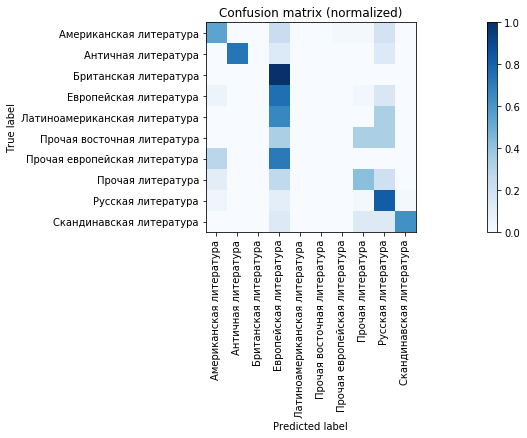

In [18]:
%%time

predict(count_vectorizer, logreg, test_data['text'], test_data['tradition'], traditions)

In [19]:
%%time

count_vectorizer_lemmatized = count_vectorizer.set_params(stop_words=None)
train_data_features_lemmatized = count_vectorizer_lemmatized.fit_transform(train_data['text_pymystem'])

CPU times: user 12.9 s, sys: 1.03 s, total: 13.9 s
Wall time: 14.9 s


In [20]:
%%time

logreg = logreg.fit(train_data_features_lemmatized, train_data['tradition'])

CPU times: user 1.8 s, sys: 40.8 ms, total: 1.84 s
Wall time: 2.02 s


accuracy 0.7185430463576159
confusion matrix
 [[29  0  0  9  0  0  0  1  5  0]
 [ 0 12  0  2  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 5  0  0 82  0  0  1  3  7  1]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  1  1  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 1  0  0  7  0  0  0  8  3  0]
 [ 4  0  0 14  0  0  0  0 84  0]
 [ 0  0  0  5  0  0  0  0  1  2]]
(row=expected, col=predicted)
CPU times: user 3.54 s, sys: 174 ms, total: 3.72 s
Wall time: 4.37 s


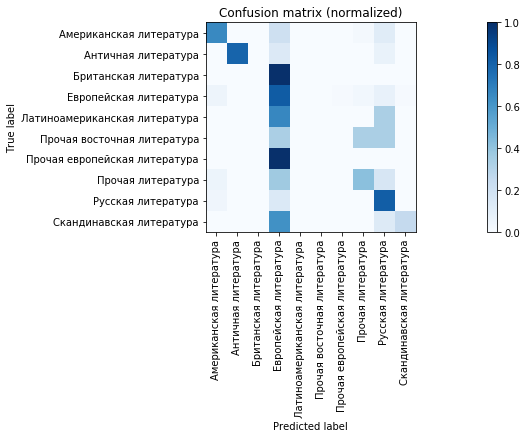

In [21]:
%%time

predict(count_vectorizer_lemmatized, logreg, test_data['text_pymystem'], test_data['tradition'], traditions)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [22]:
tradition_tag_id = 0
print(traditions[tradition_tag_id])
most_influential_words(count_vectorizer, logreg, tradition_tag_id)

Американская литература


['часть',
 'доллар',
 'ферма',
 'банк',
 'индеец',
 'штат',
 'тома',
 'мост',
 'находиться',
 'дерево']

### Character N-grams

A character _n-gram_ is a chunk of a document of length _n_. It is a poor man's tokenizer but sometimes works well. The parameter _n_ depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones.

In [23]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['text'])

logreg = logreg.fit(train_data_features, train_data['tradition'])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU times: user 1min 17s, sys: 4.77 s, total: 1min 22s
Wall time: 3min 20s


In [24]:
n_gram_vectorizer.get_feature_names()[50:60]

[' вм', ' вме', ' вн', ' во', ' во ', ' воз', ' вос', ' вр', ' вре', ' врем']

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

accuracy 0.695364238410596
confusion matrix
 [[25  0  0 11  0  0  0  0  7  1]
 [ 0 11  0  2  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 9  0  0 68  0  0  1  2 19  0]
 [ 1  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  1  0]
 [ 1  1  0  5  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0 10  5  1]
 [ 2  0  0  6  0  0  0  1 93  0]
 [ 1  0  0  3  0  0  0  0  1  3]]
(row=expected, col=predicted)


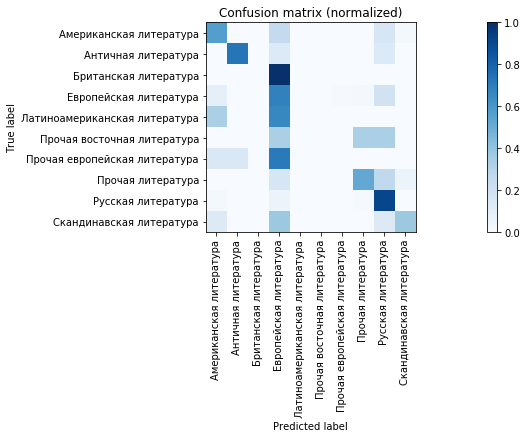

In [25]:
predict(n_gram_vectorizer, logreg, test_data['text'], test_data['tradition'], traditions)

### TF-IDF

[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a little more advanced way to count words in a document.
It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.


In [26]:
%%time
tf_vect = TfidfVectorizer(min_df=2, tokenizer=TOKENIZER)
train_data_features = tf_vect.fit_transform(train_data['text_pymystem'])

logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tradition'])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU times: user 17.1 s, sys: 355 ms, total: 17.5 s
Wall time: 18.1 s


In [27]:
tf_vect.get_feature_names()[1000:1010]

['беготня',
 'бегство',
 'бегун',
 'беда',
 'бедненький',
 'беднеть',
 'бедно',
 'бедность',
 'беднота',
 'бедный']

accuracy 0.7649006622516556
confusion matrix
 [[29  0  0 11  0  0  0  0  4  0]
 [ 0 11  0  3  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 5  1  0 87  0  0  0  0  6  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  9  3  0]
 [ 2  0  0  7  0  0  0  0 93  0]
 [ 0  0  0  5  0  0  0  0  1  2]]
(row=expected, col=predicted)


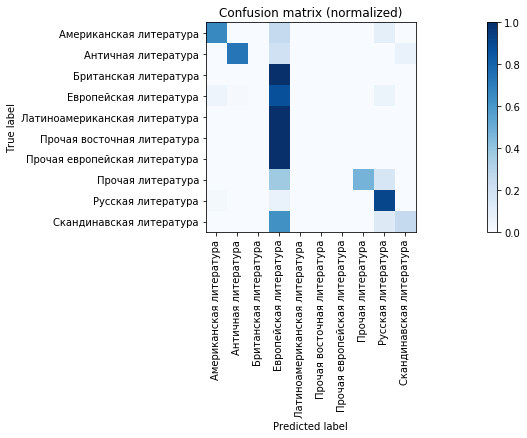

In [28]:
predict(tf_vect, logreg, test_data['text_pymystem'], test_data['tradition'], traditions)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [29]:
tradition_tag_id = 0
print(traditions[tradition_tag_id])
most_influential_words(tf_vect, logreg, tradition_tag_id)

Американская литература


['питер',
 'доллар',
 'лэнгдон',
 'джек',
 'чарли',
 'нью',
 'юджин',
 'кира',
 'ганин',
 'индеец']

# Averaging word vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the [word2vec embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). See Chris Moody's [video](https://www.youtube.com/watch?v=vkfXBGnDplQ) for a great introduction to word2vec. 


First we load a word2vec model. It has been pre-trained by Google on a 100 billon word Google News corpus. You can play with this model using a fun [web-app](http://rare-technologies.com/word2vec-tutorial/#app).

Link to the web-app: http://rare-technologies.com/word2vec-tutorial/#app

Vocabulary size: 3 mln words. 

__Warning__: 3 mins to load, takes 4 GB of RAM.

In [30]:
%%time 

path = '/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model'
model = FastText.load(os.getcwd() + path)
model.init_sims(replace=True)

2018-09-29 02:30:08,146 : INFO : loading FastText object from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model
2018-09-29 02:30:26,589 : INFO : loading wv recursively from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.* with mmap=None
2018-09-29 02:30:26,594 : INFO : loading syn0_vocab from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy with mmap=None
2018-09-29 02:30:27,388 : INFO : loading syn0 from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy with mmap=None
2018-09-29 02:30:28,345 : INFO : setting ignored attribute syn0norm to None
2018-09-29 02:30:28,347 : INFO : setting ignored attr

CPU times: user 14.1 s, sys: 6.82 s, total: 20.9 s
Wall time: 42.6 s


Example vocabulary

In [31]:
from itertools import islice
list(islice(model.wv.vocab, 0, 20))

['славдом',
 'лучок',
 'ронц',
 'никитин',
 'flashpoint',
 'балинезийский',
 'дитенок',
 'облезать',
 'аплодировать',
 'эксгумация',
 'ssangyong',
 'буонаротти',
 'лобко',
 'куха',
 'теплякова',
 'аs',
 'лесбос',
 'аблация',
 'имущество',
 'шипр']

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?




The most naive way is just to take an average. [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU) has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book
 ‘A tale of two cities’ should add up to 'class-struggle’

In [33]:
test_tokenized = test_data['text_pymystem_list'].values
train_tokenized = train_data['text_pymystem_list'].values

In [34]:
%%time
X_train_word_average = word_averaging_list(model.wv, train_tokenized)
X_test_word_average = word_averaging_list(model.wv, test_tokenized)

CPU times: user 11.1 s, sys: 79.1 ms, total: 11.1 s
Wall time: 11.2 s


Let's see how KNN and logistic regression classifiers perform on these word-averaging document features.

In [35]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tradition)

CPU times: user 8.44 ms, sys: 0 ns, total: 8.44 ms
Wall time: 8.37 ms


In [36]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

CPU times: user 28.4 ms, sys: 22.1 ms, total: 50.6 ms
Wall time: 30 ms


accuracy 0.7152317880794702
confusion matrix
 [[35  0  0  8  0  0  0  0  1  0]
 [ 0 13  0  2  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [14  5  1 73  0  0  0  2  3  1]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  2  0  1  0  0  0  0]
 [ 0  0  0  6  0  0  0  1  0  0]
 [ 0  1  0  8  0  0  0  9  1  0]
 [ 2  3  1 10  0  0  0  5 81  0]
 [ 1  0  0  2  0  0  0  1  0  4]]
(row=expected, col=predicted)


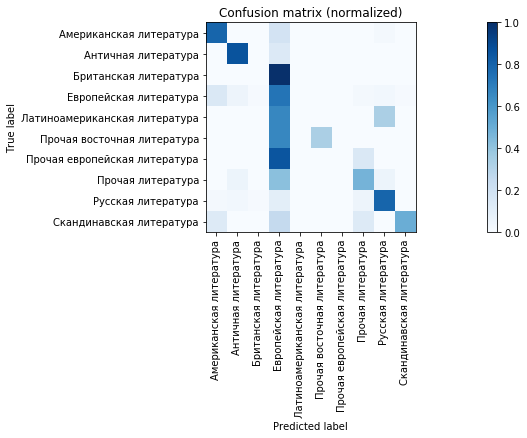

In [37]:
evaluate_prediction(predicted, test_data.tradition, traditions)

KNN is even worse than the naive 'everything is comedy' baseline! Let's see if logistic regression is better.

In [38]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data.tradition)
predicted = logreg.predict(X_test_word_average)

CPU times: user 4.23 s, sys: 219 ms, total: 4.45 s
Wall time: 4.21 s


accuracy 0.7384105960264901
confusion matrix
 [[29  0  3  8  0  0  0  1  3  0]
 [ 0 12  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 9  1  0 73  1  0  0  4  9  2]
 [ 1  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  1  0  1  0  0  1  0]
 [ 0  1  0  5  0  0  0  1  0  0]
 [ 0  0  0  6  0  0  0 13  0  0]
 [ 5  0  0  6  0  0  0  2 89  0]
 [ 0  0  0  1  0  0  0  0  1  6]]
(row=expected, col=predicted)


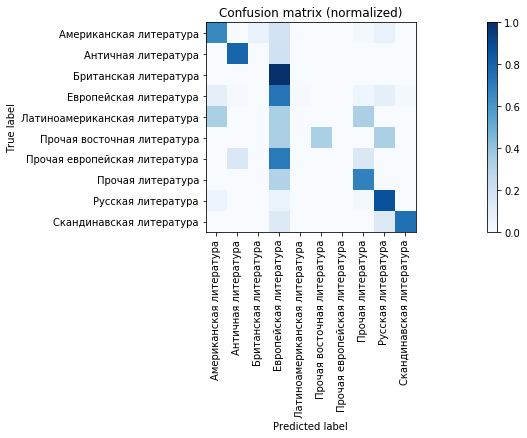

In [39]:
evaluate_prediction(predicted, test_data.tradition, traditions)

Now just for fun let's see if text summarisation works on our data. Let's pick a plot and see which words it averages to.

In [40]:
test_data.iloc()[56]['text']

'Семнадцатилетний Мелькур вступил в свет, «обладая всем, что требуется, дабы не остаться незамеченным». От отца он унаследовал прекрасное имя, со стороны матери его ожидало большое состояние. Время было мирное, и Мелькур ни о чем не помышлял, кроме удовольствий. Среди суеты и блеска юноша страдал от сердечной пустоты и мечтал изведать любовь, о которой имел лишь самое смутное представление. Наивный и неопытный, Мелькур не знал, как завязываются любовные связи в высшем кругу. С одной стороны, он был о себе достаточно высокого мнения, с другой — полагал, что успех у женщин может иметь только человек выдающийся, и не надеялся заслужить их благосклонность. Мелькур стал все больше думать о подруге своей матери маркизе де Люрсе и убедил себя, что влюблён в неё. Некогда маркиза слыла кокеткой и даже ветреницей, но впоследствии усвоила строгий и добродетельный тон, поэтому Мелькур, не знавший о её прошлом, считал её неприступной. Маркиза без труда догадалась о чувствах Мелькура и была готова н

In [41]:
model.wv.most_similar(positive=[X_test_word_average[56]], restrict_vocab=100000, topn=30)[0:20]

[('опростоволоситься', 0.7897706627845764),
 ('симоронить', 0.7883868217468262),
 ('гленарывать', 0.7708706259727478),
 ('разоткровенничаться', 0.7665129899978638),
 ('растрогаться', 0.760732889175415),
 ('даринька', 0.7581226825714111),
 ('думать', 0.7577769756317139),
 ('кажется', 0.7547581791877747),
 ('примолкать', 0.7545772790908813),
 ('вернее', 0.7522390484809875),
 ('порассказать', 0.7449817657470703),
 ('затосковать', 0.7414664030075073),
 ('присоветовать', 0.7414649724960327),
 ('заспорить', 0.7407478094100952),
 ('уговариваться', 0.7404695749282837),
 ('нездоровиться', 0.7393044233322144),
 ('расстараться', 0.7383365035057068),
 ('застесняться', 0.7381041049957275),
 ('обратиться', 0.7377612590789795),
 ('смериться', 0.7364529371261597)]

# Doc2Vec

A [paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) by Google suggests a model for document classification called Paragraph Vectors Doc2Vec or Doc2vec in short. It is very similar to word2vec. 

It introduces 'a tag' - a word that is in every context in the document.

For our first try we tag every plot with its genre. This makes it 'semi-supervised' learning - the genre labels is just one objective among many.

In [42]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [43]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['text_pymystem_list'], tags=[r.tradition]), axis=1)

In [44]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['text_pymystem_list'], tags=[r.tradition]), axis=1)

This is what a training entry looks like - an example plot tagged by 'sci-fi'.

In [45]:
test_tagged.values[50]

TaggedDocument(words=['жизнь', 'необыкновенный', 'удивительный', 'приключение', 'робинзон', 'крузо', 'моряк', 'йорк', 'проживать', 'год', 'полный', 'одиночество', 'необитаемый', 'остров', 'берег', 'америка', 'близ', 'устье', 'река', 'ориноко', 'выбрасывать', 'кораблекрушение', 'время', 'который', 'весь', 'экипаж', 'корабль', 'кроме', 'погибать', 'изложение', 'неожиданный', 'освобождение', 'пират', 'написать', 'робинзон', 'третий', 'сын', 'семья', 'баловень', 'готовить', 'ремесло', 'детский', 'год', 'голова', 'набивать', 'всякий', 'бредень', 'главный', 'образ', 'мечта', 'морской', 'путешествие', 'старший', 'брат', 'погибать', 'фландрия', 'сражаться', 'испанец', 'весть', 'пропадать', 'средний', 'поэтому', 'дома', 'слышать', 'хотеть', 'отпускать', 'последний', 'сын', 'море', 'отец', 'человек', 'степенный', 'умный', 'слезный', 'умолять', 'стремиться', 'скромный', 'существование', 'весь', 'лад', 'превозносить', 'средний', 'состояние', 'уберегать', 'человек', 'здравомыслящий', 'злой', 'превр

In [46]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=-1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

/home/zu_ann/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/home/zu_ann/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2018-09-29 02:31:08,426 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-09-29 02:31:08,428 : INFO : collecting all words and their counts
2018-09-29 02:31:08,428 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-09-29 02:31:08,896 : INFO : collected 52366 word types and 10 unique tags from a corpus of 1208 examples and 1012106 words
2018-09-29 02:31:08,897 

CPU times: user 48.7 s, sys: 77.1 ms, total: 48.7 s
Wall time: 48.9 s


Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change.

In [47]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 10.1 s, sys: 10.6 ms, total: 10.1 s
Wall time: 10.1 s


accuracy 0.33774834437086093
confusion matrix
 [[ 0  0  0 36  0  0  0  0  8  0]
 [ 0  0  0 14  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 85  0  0  0  0 14  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  4  0  0  0  0  3  0]
 [ 0  0  0 14  0  0  0  0  5  0]
 [ 0  0  0 85  0  0  0  0 17  0]
 [ 0  0  0  8  0  0  0  0  0  0]]
(row=expected, col=predicted)


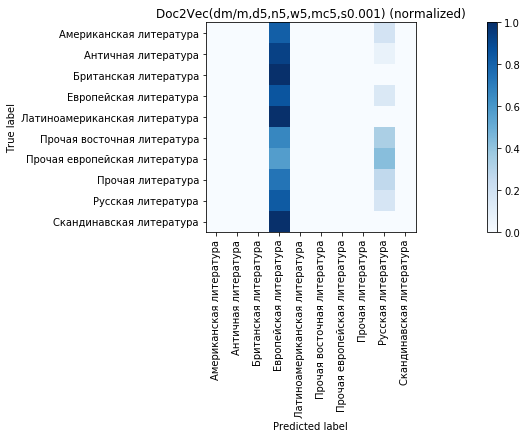

In [48]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, traditions, title=str(doc2vec_model))

KNN gives a lower accuracy than logistic regression.

2018-09-29 02:32:08,198 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.10927152317880795
confusion matrix
 [[11  2  6  4  7  2  1  1  8  2]
 [ 1  0  2  1  3  1  1  1  1  4]
 [ 1  0  1  0  0  0  0  0  0  0]
 [11 11 14 14 12  6  7 10  6  8]
 [ 1  0  1  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  1]
 [ 1  0  1  0  1  0  1  1  0  2]
 [ 4  3  1  1  2  1  0  3  2  2]
 [11  7  8  7 10 14 13 16  3 13]
 [ 0  3  1  0  1  0  2  1  0  0]]
(row=expected, col=predicted)
CPU times: user 337 ms, sys: 417 ms, total: 754 ms
Wall time: 300 ms


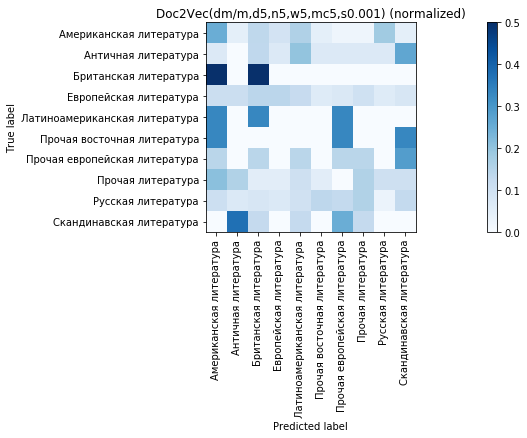

In [49]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, traditions, str(doc2vec_model))

Doc2vec gives us a vector for each genre so we can see which genres are close together.

In [50]:
doc2vec_model.docvecs.most_similar('Русская литература')

[('Прочая восточная литература', 0.7542995810508728),
 ('Прочая литература', 0.5574924349784851),
 ('Латиноамериканская литература', 0.5107288360595703),
 ('Американская литература', 0.3840237855911255),
 ('Скандинавская литература', 0.21243754029273987),
 ('Античная литература', -0.1272784173488617),
 ('Европейская литература', -0.6975723505020142),
 ('Прочая европейская литература', -0.7290286421775818),
 ('Британская литература', -0.7735009789466858)]

Words surrounding the 'sci-fi' tag describe it pretty accurately!

In [51]:
model.wv.most_similar('Русская литература')

[('восточнопрусский', 0.7164652347564697),
 ('сочинительский', 0.7103330492973328),
 ('старобелорусский', 0.7035158276557922),
 ('залесская', 0.7008966207504272),
 ('вокульский', 0.6994539499282837),
 ('старосельская', 0.6962095499038696),
 ('антропонимический', 0.6920877695083618),
 ('золотусский', 0.6917855739593506),
 ('миропольский', 0.6910200715065002),
 ('староства', 0.6906902194023132)]

### Doc2vec exercise

10 mins

Find the random seed that gives the best prediction. :)



accuracy 0.33774834437086093
confusion matrix
 [[ 0  0  0 36  0  0  0  0  8  0]
 [ 0  0  0 14  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 85  0  0  0  0 14  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  4  0  0  0  0  3  0]
 [ 0  0  0 14  0  0  0  0  5  0]
 [ 0  0  0 85  0  0  0  0 17  0]
 [ 0  0  0  8  0  0  0  0  0  0]]
(row=expected, col=predicted)


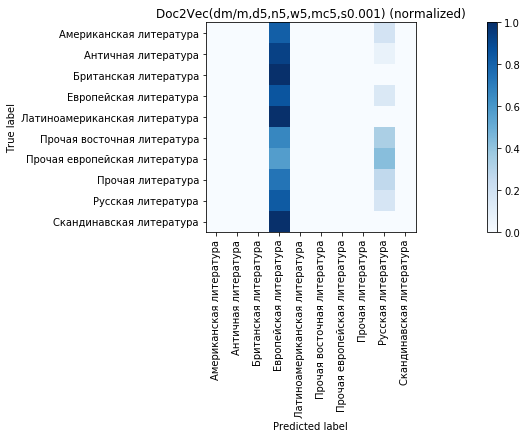

In [52]:
seed = 100

doc2vec_model.seed = seed
doc2vec_model.random = random.RandomState(seed)


test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])


logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5, random_state=42)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, traditions, title=str(doc2vec_model))

# Deep IR

'Deep IR' is a technique developed by  [“Document Classification by Inversion of Distributed Language Representations”, Matt Taddy](http://arxiv.org/pdf/1504.07295v3.pdf). Matt has contributed a gensim [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) - great source of more in depth information.

In short the algorithm is:

1. Train a word2vec model only on comedy plots.

2. Trian another model only on sci-fi, another on romance etc. Get 6 models - one for each genre.

3. Take a plot and see which model fits it best using Bayes' Theorem



The tokenization is different from other methods. The reason for this is that we are following an original approach in the paper. The purpose of this tutorial is to see how the models behave out of the box.

We just clean non-alphanumeric characters and split by sentences.

In [53]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


In [54]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tradition'],\
        'x':[clean(s).split() for s in sentences(row['text'])]}


In [55]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 13.3 s, sys: 593 ms, total: 13.9 s
Wall time: 15.4 s


In [56]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [57]:
def tag_sentences(reviews, stars=traditions):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

An example `sci-fi` sentence:

In [58]:
next(tag_sentences(revtrain, traditions[0]))

['семнадцатилетний',
 'холден',
 'колфилд',
 'находящийся',
 'санатории',
 'вспоминает',
 'ту',
 'сумасшедшую',
 'историю',
 'которая',
 'случилась',
 'прошлым',
 'рождеством',
 '»,',
 'после',
 'чего',
 'он',
 'чуть',
 'не',
 'отдал',
 'концы',
 '»,',
 'долго',
 'болел',
 'теперь',
 'вот',
 'проходит',
 'курс',
 'лечения',
 'вскоре',
 'надеется',
 'вернуться',
 'домой']

We train our own 6 word2vec models from scratch. 

In [59]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(traditions))]
for i in range(len(traditions)):
    slist = list(tag_sentences(revtrain, traditions[i]))
    print(traditions[i], "genre (", len(slist), ")")
    genremodels[i].train(  slist, total_examples=len(slist), epochs=1 )
# get the probs (note we give docprob a list of lists of words, plus the models)


2018-09-29 02:32:37,542 : INFO : collecting all words and their counts
2018-09-29 02:32:37,543 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-29 02:32:37,612 : INFO : PROGRESS: at sentence #10000, processed 118868 words, keeping 32763 word types


Word2Vec(vocab=0, size=100, alpha=0.025)


2018-09-29 02:32:37,678 : INFO : PROGRESS: at sentence #20000, processed 239297 words, keeping 53138 word types
2018-09-29 02:32:37,741 : INFO : PROGRESS: at sentence #30000, processed 354493 words, keeping 68929 word types
2018-09-29 02:32:37,803 : INFO : PROGRESS: at sentence #40000, processed 474592 words, keeping 83245 word types
2018-09-29 02:32:37,874 : INFO : PROGRESS: at sentence #50000, processed 591810 words, keeping 94774 word types
2018-09-29 02:32:37,941 : INFO : PROGRESS: at sentence #60000, processed 705161 words, keeping 105458 word types
2018-09-29 02:32:38,003 : INFO : PROGRESS: at sentence #70000, processed 818073 words, keeping 114838 word types
2018-09-29 02:32:38,071 : INFO : PROGRESS: at sentence #80000, processed 937099 words, keeping 124199 word types
2018-09-29 02:32:38,137 : INFO : PROGRESS: at sentence #90000, processed 1056395 words, keeping 132932 word types
2018-09-29 02:32:38,203 : INFO : PROGRESS: at sentence #100000, processed 1176912 words, keeping 14

Американская литература genre ( 17899 )


2018-09-29 02:32:56,445 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-29 02:32:56,450 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-29 02:32:56,456 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-29 02:32:56,476 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-29 02:32:56,478 : INFO : EPOCH - 1 : training on 203712 raw words (159192 effective words) took 0.5s, 342788 effective words/s
2018-09-29 02:32:56,479 : INFO : training on a 203712 raw words (159192 effective words) took 0.5s, 328442 effective words/s
2018-09-29 02:32:56,481 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-09-29 02:32:56,487 : INFO : training model with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-09-29 02:32:56,580 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09

Античная литература genre ( 3727 )
Британская литература genre ( 2015 )


2018-09-29 02:32:56,687 : INFO : training on a 25779 raw words (20225 effective words) took 0.1s, 268170 effective words/s
2018-09-29 02:32:56,688 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-09-29 02:32:56,696 : INFO : training model with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


Европейская литература genre ( 43800 )


2018-09-29 02:32:57,727 : INFO : EPOCH 1 - PROGRESS: at 85.94% examples, 364354 words/s, in_qsize 7, out_qsize 0
2018-09-29 02:32:57,847 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-29 02:32:57,858 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-29 02:32:57,862 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-29 02:32:57,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-29 02:32:57,878 : INFO : EPOCH - 1 : training on 550566 raw words (435271 effective words) took 1.2s, 372167 effective words/s
2018-09-29 02:32:57,879 : INFO : training on a 550566 raw words (435271 effective words) took 1.2s, 368471 effective words/s
2018-09-29 02:32:57,882 : INFO : training model with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-09-29 02:32:57,905 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-29 02:32:57,91

Латиноамериканская литература genre ( 879 )
Прочая восточная литература genre ( 736 )
Прочая европейская литература genre ( 1498 )
Прочая литература genre ( 8077 )


2018-09-29 02:32:58,261 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-29 02:32:58,267 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-29 02:32:58,275 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-29 02:32:58,291 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-29 02:32:58,292 : INFO : EPOCH - 1 : training on 88450 raw words (69524 effective words) took 0.2s, 325235 effective words/s
2018-09-29 02:32:58,293 : INFO : training on a 88450 raw words (69524 effective words) took 0.2s, 310911 effective words/s
2018-09-29 02:32:58,294 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-09-29 02:32:58,299 : INFO : training model with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


Русская литература genre ( 34602 )


2018-09-29 02:32:59,066 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-29 02:32:59,074 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-29 02:32:59,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-29 02:32:59,097 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-29 02:32:59,099 : INFO : EPOCH - 1 : training on 379919 raw words (292243 effective words) took 0.8s, 369633 effective words/s
2018-09-29 02:32:59,100 : INFO : training on a 379919 raw words (292243 effective words) took 0.8s, 366134 effective words/s
2018-09-29 02:32:59,104 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2018-09-29 02:32:59,109 : INFO : training model with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5
2018-09-29 02:32:59,164 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09

Скандинавская литература genre ( 2869 )
CPU times: user 24.9 s, sys: 438 ms, total: 25.3 s
Wall time: 21.7 s


Now we will compute most likely class for a plot using Bayes' Theorem formula.

<img src='images/deep_ir_bayes.png' width=600>

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper. (from the original [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) by Matt Taddy.

In [60]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [61]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: traditions[x])

2018-09-29 02:32:59,297 : INFO : scoring sentences with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-09-29 02:33:00,310 : INFO : PROGRESS: at 2870000.00% sentences, 28658 sentences/s
2018-09-29 02:33:00,317 : INFO : reached end of input; waiting to finish 12 outstanding jobs
2018-09-29 02:33:00,352 : INFO : scoring 29991 sentences took 1.0s, 28736 sentences/s
2018-09-29 02:33:00,353 : INFO : scoring sentences with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-09-29 02:33:01,342 : INFO : reached end of input; waiting to finish 12 outstanding jobs
2018-09-29 02:33:01,359 : INFO : PROGRESS: at 2890000.00% sentences, 28753 sentences/s
2018-09-29 02:33:01,379 : INFO : scoring 29991 sentences took 1.0s, 29250 sentences/s
2018-09-29 02:33:01,381 : INFO : scoring sentences with 4 workers on 33704 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-09-29 02:33:02,350 

CPU times: user 14.8 s, sys: 2.36 s, total: 17.1 s
Wall time: 10.3 s


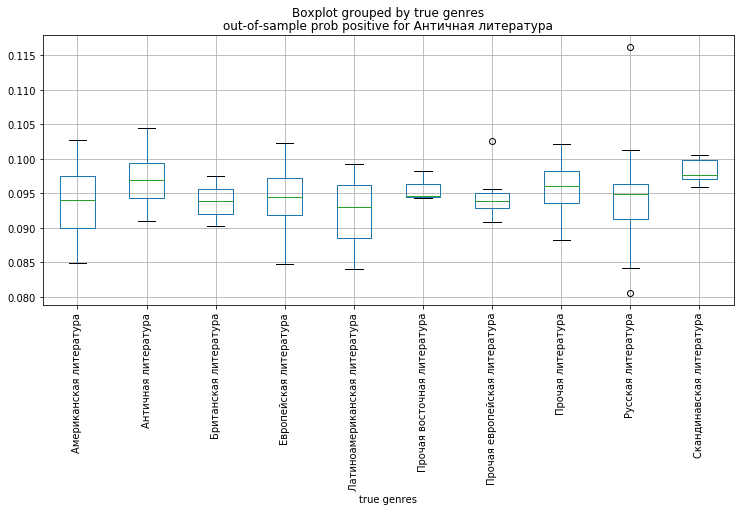

In [62]:
tag_index = 1
col_name = "out-of-sample prob positive for " + traditions[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5), rot=90)

In [63]:
target = [r['y'] for r in revtest]

accuracy 0.4205298013245033
confusion matrix
 [[15  0  0 20  0  0  0  9  0  0]
 [ 1  0  0 12  0  0  0  0  2  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 85  0  0  0 12  2  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  1  0  0]
 [ 0  0  0 13  0  0  0  3  3  0]
 [ 5  0  0 59  0  1  0 13 24  0]
 [ 0  0  0  4  0  0  0  4  0  0]]
(row=expected, col=predicted)


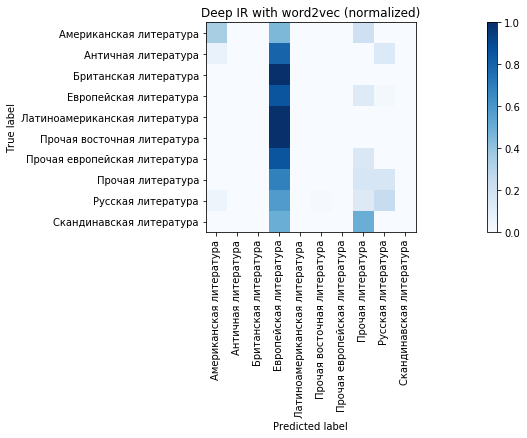

In [64]:
evaluate_prediction(predictions, target, traditions, "Deep IR with word2vec")

Performance is worse than for a naive predictor that says that everything is `comedy`.

### Why?



It is because we train each word2vec model from scratch on a very small sample of about 30k words.

This model needs more data.

# Word Mover's Distance

<img src='images/wmd_gelato.png'>

Image from 
http://tech.opentable.com/2015/08/11/navigating-themes-in-restaurant-reviews-with-word-movers-distance/

Word Mover's Distance is a new algorithm developed in by [Matt Kusner](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf). There is Matt's code on [github](https://github.com/mkusner/wmd) and also Gensim can compute WMD similarity in this [PR](https://github.com/piskvorky/gensim/pull/659).

For KNN the best code is from [Vlad Niculae's blog](http://vene.ro/blog/word-movers-distance-in-python.html). He is a contributor to sklearn and did great integration of WMD with sklearn KNN.

__Warning__: Write 7 GB file on disk to use memory mapping.

## __This part requires Python 3__

In [65]:
%%time

data_folder = '/media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/data/'

fp = np.memmap(data_folder + "embed.dat", dtype=np.double, mode='w+', shape=model.wv.vectors_norm.shape)
fp[:] = model.wv.vectors_norm[:]

with smart_open(data_folder + "embed.vocab", "w") as f: 
    for _, w in sorted((voc.index, word) for word, voc in model.wv.vocab.items()):
        print(w.encode('utf8'), file=f)
# del fp, model.wv

CPU times: user 3.26 s, sys: 3.92 s, total: 7.18 s
Wall time: 28min 20s


In [66]:
model.wv.vocab

{'славдом': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a90c66d68>,
 'лучок': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a848cf780>,
 'ронц': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a857e7ef0>,
 'никитин': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a90b5b630>,
 'flashpoint': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a855d2160>,
 'балинезийский': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a84130cf8>,
 'дитенок': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a8505ebe0>,
 'облезать': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a85fd8748>,
 'аплодировать': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a8474b048>,
 'эксгумация': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a91051a90>,
 'ssangyong': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a910b7160>,
 'буонаротти': <gensim.models.deprecated.keyedvectors.Vocab at 0x7f1a8507ae48>,
 'лобко': <gensim.models.deprecated.keyedvectors.Vocab at 

In [67]:
%%time

# я уменьшила размер на порядок (минус один 0), иначе memory error
W = np.memmap(data_folder + "embed.dat", dtype=np.double, mode="r", shape=(30000, 300))
with smart_open(data_folder + "embed.vocab", mode="rb") as f:
    vocab_list = [line.strip() for line in f]

CPU times: user 120 ms, sys: 36 ms, total: 156 ms
Wall time: 230 ms


In [68]:
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

In [69]:
# проблема с переводом в байты (должно получаться в одном виде):

In [70]:
vocab_dict

{b"b'\\xd0\\xbe\\xd1\\x81\\xd1\\x8f\\xd0\\xb7\\xd0\\xb0\\xd1\\x82\\xd1\\x8c'": 42514,
 b"b'\\xd0\\xba\\xd1\\x8e\\xd1\\x80\\xd0\\xb5\\xd1\\x82\\xd0\\xb0\\xd0\\xb6'": 64457,
 b"b'gva'": 84543,
 b"b'\\xd0\\xb4\\xd0\\xbe\\xd0\\xbc\\xd0\\xbe\\xd0\\xbb\\xd0\\xb8\\xd0\\xbd\\xd0\\xba'": 162603,
 b"b'\\xd0\\xba\\xd0\\xbe\\xd0\\xbd\\xd1\\x81\\xd1\\x8c\\xd0\\xb5\\xd1\\x80\\xd0\\xb6'": 25262,
 b"b'\\xd1\\x86\\xd0\\xba\\xd0\\xb8'": 101453,
 b"b'\\xd0\\xb4\\xd0\\xb5\\xd1\\x86\\xd0\\xbb'": 129607,
 b"b'\\xd0\\xbe\\xd0\\xb1\\xd1\\x89\\xd0\\xb5\\xd0\\xbd\\xd0\\xb0\\xd1\\x80\\xd0\\xbe\\xd0\\xb4\\xd0\\xbd\\xd1\\x8b\\xd0\\xb9'": 28196,
 b"b'\\xd0\\xb3\\xd0\\xb0\\xd1\\x81\\xd0\\xba\\xd0\\xb0\\xd1\\x80'": 126900,
 b"b'\\xd0\\xba\\xd0\\xbe\\xd0\\xbc\\xd0\\xba\\xd0\\xb0\\xd1\\x82\\xd1\\x8c\\xd1\\x81\\xd1\\x8f'": 165506,
 b"b'\\xd1\\x82\\xd0\\xb5\\xd1\\x85\\xd0\\xb4\\xd0\\xbe\\xd0\\xba\\xd1\\x83\\xd0\\xbc\\xd0\\xb5\\xd0\\xbd\\xd1\\x82\\xd0\\xb0\\xd1\\x86\\xd0\\xb8\\xd1\\x8f'": 88270,
 b"b'\\xd0\\xb8\\xd0\\xbd\

In [73]:
# the word2vec model was loaded with strings as byte-arrays so need to convert
def convert_to_vocab_bytes(s):
    return bytes("b'" + s + "'", encoding='utf-8')   

In [74]:
convert_to_vocab_bytes('стол')

b"b'\xd1\x81\xd1\x82\xd0\xbe\xd0\xbb'"

### sklearn KNN integration with WMD

In [ ]:
"""%%file word_movers_knn.py"""

# Authors: Vlad Niculae, Matt Kusner
# License: Simplified BSD

import numpy as np
from sklearn.metrics import euclidean_distances
from sklearn.externals.joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_array
from sklearn.cross_validation import check_cv
from sklearn.metrics.scorer import check_scoring
from sklearn.preprocessing import normalize

from pyemd import emd


class WordMoversKNN(KNeighborsClassifier):
    """K nearest neighbors classifier using the Word Mover's Distance.

    Parameters
    ----------
    
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for :meth:`k_neighbors` queries.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
    
    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.
        
    References
    ----------
    
    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    _pairwise = False

    def __init__(self, W_embed, n_neighbors=1, n_jobs=1, verbose=False):
        self.W_embed = W_embed
        self.verbose = verbose
        super(WordMoversKNN, self).__init__(n_neighbors=n_neighbors, n_jobs=n_jobs,
                                            metric='precomputed', algorithm='brute')

    def _wmd(self, i, row, X_train):
        """Compute the WMD between training sample i and given test row.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        """
        union_idx = np.union1d(X_train[i].indices, row.indices)
        W_minimal = self.W_embed[union_idx]
        W_dist = euclidean_distances(W_minimal)
        bow_i = X_train[i, union_idx].A.ravel()
        bow_j = row[:, union_idx].A.ravel()
        return emd(bow_i, bow_j, W_dist)
    
    def _wmd_row(self, row, X_train):
        """Wrapper to compute the WMD of a row with all training samples.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        Useful for parallelization.
        """
        n_samples_train = X_train.shape[0]
        return [self._wmd(i, row, X_train) for i in range(n_samples_train)]

    def _pairwise_wmd(self, X_test, X_train=None):
        """Computes the word mover's distance between all train and test points.
        
        Parallelized over rows of X_test.
        
        Assumes that train and test samples are sparse BOW vectors summing to 1.
        
        Parameters
        ----------
        X_test: scipy.sparse matrix, shape: (n_test_samples, vocab_size)
            Test samples.
        
        X_train: scipy.sparse matrix, shape: (n_train_samples, vocab_size)
            Training samples. If `None`, uses the samples the estimator was fit with.
        
        Returns
        -------
        dist : array, shape: (n_test_samples, n_train_samples)
            Distances between all test samples and all train samples.
        
        """
        n_samples_test = X_test.shape[0]
        
        if X_train is None:
            X_train = self._fit_X

        dist = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
            delayed(self._wmd_row)(test_sample, X_train)
            for test_sample in X_test)

        return np.array(dist)

    def fit(self, X, y):
        """Fit the model using X as training data and y as target values

        Parameters
        ----------
        X : scipy sparse matrix, shape: (n_samples, n_features)
            Training data. 

        y : {array-like, sparse matrix}
            Target values of shape = [n_samples] or [n_samples, n_outputs]

        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        return super(WordMoversKNN, self).fit(X, y)

    def predict(self, X):
        """Predict the class labels for the provided data
        Parameters
        ----------
        X : scipy.sparse matrix, shape (n_test_samples, vocab_size)
            Test samples.

        Returns
        -------
        y : array of shape [n_samples]
            Class labels for each data sample.
        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        dist = self._pairwise_wmd(X)
        return super(WordMoversKNN, self).predict(dist)
    
    
class WordMoversKNNCV(WordMoversKNN):
    """Cross-validated KNN classifier using the Word Mover's Distance.

    Parameters
    ----------
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors_try : sequence, optional
        List of ``n_neighbors`` values to try.
        If None, tries 1-5 neighbors.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, StratifiedKFold is used.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.

    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.

    Attributes
    ----------
    cv_scores_ : array, shape (n_folds, len(n_neighbors_try))
        Test set scores for each fold.

    n_neighbors_ : int,
        The best `n_neighbors` value found.

    References
    ----------

    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    def __init__(self, W_embed, n_neighbors_try=None, scoring=None, cv=3,
                 n_jobs=1, verbose=False):
        self.cv = cv
        self.n_neighbors_try = n_neighbors_try
        self.scoring = scoring
        super(WordMoversKNNCV, self).__init__(W_embed,
                                              n_neighbors=None,
                                              n_jobs=n_jobs,
                                              verbose=verbose)

    def fit(self, X, y):
        """Fit KNN model by choosing the best `n_neighbors`.
        
        Parameters
        -----------
        X : scipy.sparse matrix, (n_samples, vocab_size)
            Data
        y : ndarray, shape (n_samples,) or (n_samples, n_targets)
            Target
        """
        if self.n_neighbors_try is None:
            n_neighbors_try = range(1, 6)
        else:
            n_neighbors_try = self.n_neighbors_try

        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)

        cv = check_cv(self.cv, X, y)
        knn = KNeighborsClassifier(metric='precomputed', algorithm='brute')
        scorer = check_scoring(knn, scoring=self.scoring)

        scores = []
        for train_ix, test_ix in cv:
            dist = self._pairwise_wmd(X[test_ix], X[train_ix])
            knn.fit(X[train_ix], y[train_ix])
            scores.append([
                scorer(knn.set_params(n_neighbors=k), dist, y[test_ix])
                for k in n_neighbors_try
            ])
        scores = np.array(scores)
        self.cv_scores_ = scores

        best_k_ix = np.argmax(np.mean(scores, axis=0))
        best_k = n_neighbors_try[best_k_ix]
        self.n_neighbors = self.n_neighbors_ = best_k

        return super(WordMoversKNNCV, self).fit(X, y)

Let's see how well it performs.

In [ ]:
test_tokenized = test_data['text_pymystem_list'].values
train_tokenized = train_data['text_pymystem_list'].values

flat_train_tokenized = [item for sublist in train_tokenized for item in sublist]
flat_test_tokenized = [item for sublist in test_tokenized for item in sublist]

To speed up performance we focus only on the words that are both in Google News model and in our dataset.

In [ ]:
# the word2vec model was loaded with strings as byte-arrays so need to convert
def convert_to_vocab_bytes(s):
    return bytes("b'" + s + "'", encoding='utf-8')    

In [ ]:
vect = CountVectorizer()
vect.fit(flat_train_tokenized)

In [ ]:
common = [word for word in vect.get_feature_names() if convert_to_vocab_bytes(word) in vocab_dict]
W_common = W[[vocab_dict[ convert_to_vocab_bytes(w)] for w in common]]

In [ ]:
vocab_dict

In [ ]:
vect.get_feature_names()

The mass of the pile of mud in the Word Mover's Distance is determined by how many times a word appears in a document. So we need a CountVectorizer.

In [ ]:
test_tokenized[0]

In [ ]:
vect = CountVectorizer(vocabulary=common, dtype=np.double)
X_train = vect.fit_transform(train_tokenized)
X_test = vect.transform(test_tokenized)

Let's train the model.

In [ ]:
knn = WordMoversKNN(n_neighbors=1, W_embed=W_common, verbose=5, n_jobs=-1)

In [ ]:
knn.fit(X_train, train_data['tradition'])

__Warning__: 10 minutes runtime on 7 cores

In [ ]:
%%time 
predicted = knn.predict(X_test)

Only 2% above the naive baseline unfortunately. WMD achieves good results on sentiment analysis in the published paper. Maybe it works better for sentiment than for topic classification that we use it here. Or maybe preprocessing can be tuned here. It is hard to debug a black box method!

In [ ]:
evaluate_prediction(predicted, test_data['tradition'], traditions)

# Conclusion

Above we shown how to run 'hello-world' in 7 different document classification techniques. It is just a beginning of exploration of their features... There are a lot of parameters that can be tuned to get the best possible results out of them. The 'hello-world' run is in no way an indication of their best peformance. The goal of this tutorial is to show the API so you can start tuning them yourself.

Out of the box "no tuning" accuracy of bag of words is not far behind more advanced techniques. 
Tune them and the pre-processing for them well first and only then reach for more advanced methods if more accuracy is absolutely needed.